## RNN (Classification)

from - http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('./rnn_data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/French.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Irish.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt']
Slusarski


In [3]:
n_categories

18

In [4]:
all_categories

['Vietnamese',
 'Russian',
 'Czech',
 'Italian',
 'French',
 'Scottish',
 'Spanish',
 'Arabic',
 'Korean',
 'Irish',
 'Polish',
 'English',
 'Japanese',
 'Greek',
 'Chinese',
 'German',
 'Portuguese',
 'Dutch']

In [5]:
category_lines['Vietnamese'][:5]

['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']

In [6]:
n_letters

57

In [7]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9183, -2.7574, -2.9193, -3.0426, -2.8916, -2.8909, -2.9213, -2.9229,
         -2.8489, -2.8200, -2.8176, -2.9864, -2.9691, -2.9232, -2.7483, -2.9840,
         -2.7984, -2.9224]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 14)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Salib
category = Czech / line = Kauphsman
category = Spanish / line = Capello
category = German / line = Wexler
category = Scottish / line = Watson
category = Irish / line = Mcneil
category = Polish / line = Szczepanski
category = Italian / line = Zini
category = Spanish / line = Toset
category = French / line = Giroux


In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

criterion = nn.NLLLoss()

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.3956 Karubo / Spanish ✗ (Japanese)
10000 10% (0m 4s) 2.4069 Kassis / Greek ✗ (Arabic)
15000 15% (0m 6s) 1.6109 Flynn / German ✗ (Irish)
20000 20% (0m 7s) 0.6376 Kawaii / Japanese ✓
25000 25% (0m 9s) 1.9295 Drummond / Irish ✗ (English)
30000 30% (0m 11s) 0.8651 Watson / Scottish ✓
35000 35% (0m 13s) 0.9772 Maradona / Spanish ✓
40000 40% (0m 15s) 1.5556 Vicario / Italian ✗ (Spanish)
45000 45% (0m 17s) 1.9524 Garofalo / Spanish ✗ (Italian)
50000 50% (0m 19s) 2.0519 Falkenrath / Irish ✗ (German)
55000 55% (0m 21s) 1.1636 Kim / Korean ✓
60000 60% (0m 23s) 2.1052 Schenck / German ✗ (Dutch)
65000 65% (0m 25s) 1.9855 Sai / Chinese ✗ (Vietnamese)
70000 70% (0m 27s) 1.4258 Nutman / Scottish ✗ (English)
75000 75% (0m 29s) 0.0640 Peeters / Dutch ✓
80000 80% (0m 31s) 0.0949 Rjavinsky / Russian ✓
85000 85% (0m 33s) 5.1555 Charlott / English ✗ (Czech)
90000 90% (0m 35s) 0.3720 Baik / Korean ✓
95000 95% (0m 37s) 0.0808 Bitar / Arabic ✓
100000 100% (0m 39s) 0.0620 Ku / Korean ✓


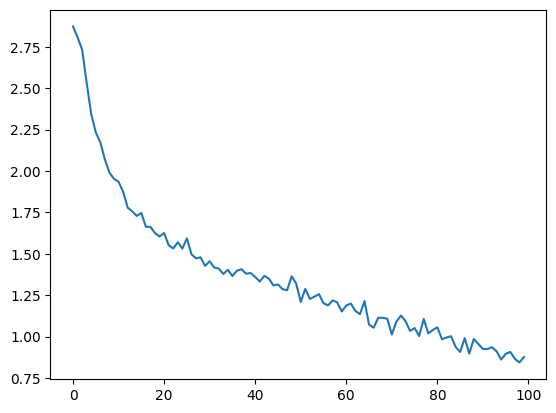

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [15]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.68) Russian
(-1.47) Irish
(-2.00) Czech

> Jackson
(-0.15) Scottish
(-2.86) English
(-3.47) Russian

> Satoshi
(-0.65) Italian
(-1.08) Japanese
(-3.22) Arabic
